<a href="https://colab.research.google.com/github/Weverton-Vitor/autoML-and-feature-engine-landsat/blob/main/baseline_nothern_gulf_pixels_analysis_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mobile Bay Data Analysis


In [1]:
!pip install mlflow pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.6 MB/s eta 0:00:00


##1. Mount Drive and Import Libs

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import joblib
import mlflow

from pyngrok import ngrok
from google.colab import drive
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1 MLFlow experiment

In [4]:
try:
  experiment_id = mlflow.create_experiment('chla_regression')
except:
  experiment_id = mlflow.get_experiment_by_name('chla_regression').experiment_id

In [5]:
mlflow.set_tracking_uri("file:///content/drive/MyDrive/water_quality/mobile_bay/notebooks/TCC/mlflow_logs")  # Caminho dentro do Google Drive
mlflow.set_experiment("chla_regression")

<Experiment: artifact_location='file:///content/drive/MyDrive/water_quality/mobile_bay/notebooks/TCC/mlflow_logs/865090260820805086', creation_time=1738677914705, experiment_id='865090260820805086', last_update_time=1738677914705, lifecycle_stage='active', name='chla_regression', tags={}>

In [6]:
# mlflow.autolog()

## 2. Explore the data

In [7]:
data_path = "/content/drive/MyDrive/water_quality/mobile_bay/data/extracted_points.csv"

In [8]:
raw_pixel_northern_gulf = pd.read_csv(data_path)

In [9]:
# Show all sheets
raw_pixel_northern_gulf.head()

,Unnamed: 0,ChlA,QA_PIXEL,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,ST_B6,Temp,date,lat,lon,name,scene_id
0,0,3.508516,5504,8262.0,8234.0,7840.0,7659.0,7363.0,7664.0,43755.0,25.11,2003-11-08,-89.9293,28.7199,Point_1,0_LT05_022040_20031105
1,1,6.123188,5504,8075.0,8240.0,7687.0,7660.0,7483.0,7495.0,43765.0,24.52,2003-11-08,-89.9998,28.8266,Point_2,1_LT05_022040_20031105
2,2,0.698540,5504,7885.0,7848.0,7532.0,7289.0,7484.0,7666.0,43695.0,24.57,2003-11-08,-90.0314,28.9242,Point_3,2_LT05_022040_20031105
3,3,1.021608,5504,7991.0,8051.0,7534.0,7290.0,7364.0,7494.0,43704.0,24.53,2003-11-08,-90.0726,28.9889,Point_4,3_LT05_022040_20031105
4,4,1.164565,5504,7996.0,7855.0,7536.0,7291.0,7485.0,7323.0,43718.0,24.59,2003-11-08,-90.1035,29.0190,Point_5,4_LT05_022040_20031105


In [10]:
raw_pixel_northern_gulf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  181 non-null    int64  
 1   ChlA        181 non-null    float64
 2   QA_PIXEL    181 non-null    int64  
 3   SR_B1       181 non-null    float64
 4   SR_B2       181 non-null    float64
 5   SR_B3       181 non-null    float64
 6   SR_B4       181 non-null    float64
 7   SR_B5       181 non-null    float64
 8   SR_B7       181 non-null    float64
 9   ST_B6       181 non-null    float64
 10  Temp        181 non-null    float64
 11  date        181 non-null    object 
 12  lat         181 non-null    float64
 13  lon         181 non-null    float64
 14  name        181 non-null    object 
 15  scene_id    181 non-null    object 
dtypes: float64(11), int64(2), object(3)
memory usage: 22.8+ KB


In [11]:
raw_pixel_northern_gulf.describe()

,Unnamed: 0,ChlA,QA_PIXEL,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,ST_B6,Temp,lat,lon
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,90.000000,3.865430,5640.243094,9791.773481,9864.922652,9445.944751,9072.469613,8462.116022,8266.204420,43425.486188,26.801281,-90.957877,28.913045
std,52.394338,5.008181,505.542070,6024.739202,6035.759141,6078.594267,5029.629079,1820.454895,1159.423265,1958.589350,3.840687,1.319618,0.324250
min,0.000000,0.110000,5442.000000,7633.000000,7624.000000,7205.000000,7075.000000,7056.000000,7006.000000,35320.000000,12.260000,-93.428470,27.999800
25%,45.000000,0.700000,5504.000000,8485.000000,8379.000000,7970.000000,7780.000000,7521.000000,7537.000000,42885.000000,24.520000,-92.383000,28.749400
50%,90.000000,1.600000,5504.000000,9195.000000,9124.000000,8784.000000,8516.000000,8053.000000,8019.000000,43858.000000,28.570000,-90.523400,28.939100
75%,135.000000,5.280000,5504.000000,9745.000000,9932.000000,9486.000000,9113.000000,8818.000000,8611.000000,44807.000000,30.010000,-89.751000,29.088380
max,180.000000,28.870000,7698.000000,65535.000000,65535.000000,65535.000000,65535.000000,22768.000000,15586.000000,45589.000000,31.730000,-88.566200,29.642700


## Normalized indices

In [12]:
def calculate_norm_indice(b1, b2):
  try:
    ndwi = (b1 - b2) / (b1 + b2)
    return ndwi
  except ZeroDivisionError:
    return np.nan

### NDWI



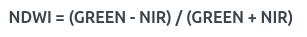

In [13]:
raw_pixel_northern_gulf['NDWI'] = raw_pixel_northern_gulf.apply(lambda row: calculate_norm_indice(row['SR_B2'], row['SR_B4']), axis=1)

### NDVI

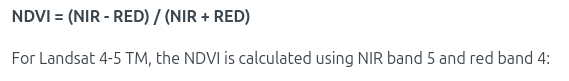

In [14]:
raw_pixel_northern_gulf['NDVI'] = raw_pixel_northern_gulf.apply(lambda row: calculate_norm_indice(row['SR_B4'], row['SR_B3']), axis=1)

### NDCI

O landsat 5 não apresenta a banda red edge 1, então podemos substituir o ndci por outro indice

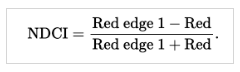

### Outro indice

### NRAVI

In [15]:
def calculate_nravi(green, nir):
  return (green - nir) / (nir + nir)

raw_pixel_northern_gulf['NRAVI'] = raw_pixel_northern_gulf.apply(lambda row: calculate_nravi(row['SR_B2'], row['SR_B4']), axis=1)

## Novas variáveis

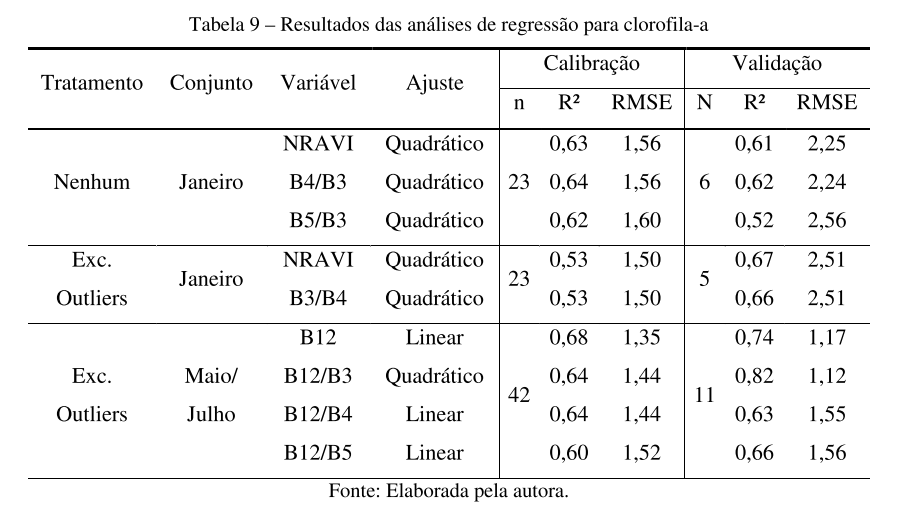

#### B4/B3 -> Red/Green

In [16]:
def calculate_red_slash_green(red, green):
  return red / green

raw_pixel_northern_gulf['red/green'] = raw_pixel_northern_gulf.apply(lambda row: calculate_red_slash_green(row['SR_B2'], row['SR_B3']), axis=1)

#### B5/B3 -> red edge/Green

In [17]:
def calculate_rededge_slash_green(red_edge, green):
  return red_edge / green

raw_pixel_northern_gulf['nir/green'] = raw_pixel_northern_gulf.apply(lambda row: calculate_rededge_slash_green(row['SR_B4'], row['SR_B2']), axis=1)

#### B4/B3 -> red/Green

In [18]:
def calculate_green_slash_red(green, red):
  return green / red

raw_pixel_northern_gulf['green/red'] = raw_pixel_northern_gulf.apply(lambda row: calculate_red_slash_green(row['SR_B2'], row['SR_B3']), axis=1)

#### B12/B3 -> SWIR2/Green

In [19]:
def calculate_swir2_slash_green(swir2, green):
  return swir2 / green

raw_pixel_northern_gulf['swir2/green'] = raw_pixel_northern_gulf.apply(lambda row: calculate_swir2_slash_green(row['SR_B7'], row['SR_B2']), axis=1)

#### B12/B4 -> SWIR2/red

In [20]:
def calculate_swir2_slash_red(swir2, red):
  return swir2 / red

raw_pixel_northern_gulf['swir2/red'] = raw_pixel_northern_gulf.apply(lambda row: calculate_swir2_slash_red(row['SR_B7'], row['SR_B3']), axis=1)

#### B12/B5 -> SWIR2/rededge

Como não temos redegde eu fiz a mudança para o nir

In [21]:
def calculate_green_slash_rededge(swir2, nir):
  return swir2 / nir

raw_pixel_northern_gulf['swir2/nir'] = raw_pixel_northern_gulf.apply(lambda row: calculate_green_slash_rededge(row['SR_B7'], row['SR_B4']), axis=1)

In [22]:
raw_pixel_northern_gulf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   181 non-null    int64  
 1   ChlA         181 non-null    float64
 2   QA_PIXEL     181 non-null    int64  
 3   SR_B1        181 non-null    float64
 4   SR_B2        181 non-null    float64
 5   SR_B3        181 non-null    float64
 6   SR_B4        181 non-null    float64
 7   SR_B5        181 non-null    float64
 8   SR_B7        181 non-null    float64
 9   ST_B6        181 non-null    float64
 10  Temp         181 non-null    float64
 11  date         181 non-null    object 
 12  lat          181 non-null    float64
 13  lon          181 non-null    float64
 14  name         181 non-null    object 
 15  scene_id     181 non-null    object 
 16  NDWI         181 non-null    float64
 17  NDVI         181 non-null    float64
 18  NRAVI        181 non-null    float64
 19  red/gree

In [23]:
raw_pixel_northern_gulf.head()

,Unnamed: 0,ChlA,QA_PIXEL,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,ST_B6,...,scene_id,NDWI,NDVI,NRAVI,red/green,nir/green,green/red,swir2/green,swir2/red,swir2/nir
0,0,3.508516,5504,8262.0,8234.0,7840.0,7659.0,7363.0,7664.0,43755.0,...,0_LT05_022040_20031105,0.036179,-0.011678,0.037538,1.050255,0.930168,1.050255,0.930775,0.977551,1.000653
1,1,6.123188,5504,8075.0,8240.0,7687.0,7660.0,7483.0,7495.0,43765.0,...,1_LT05_022040_20031105,0.036478,-0.001759,0.037859,1.071940,0.929612,1.071940,0.909587,0.975023,0.978460
2,2,0.698540,5504,7885.0,7848.0,7532.0,7289.0,7484.0,7666.0,43695.0,...,2_LT05_022040_20031105,0.036929,-0.016396,0.038345,1.041954,0.928772,1.041954,0.976809,1.017791,1.051722
3,3,1.021608,5504,7991.0,8051.0,7534.0,7290.0,7364.0,7494.0,43704.0,...,3_LT05_022040_20031105,0.049606,-0.016460,0.052195,1.068622,0.905478,1.068622,0.930816,0.994691,1.027984
4,4,1.164565,5504,7996.0,7855.0,7536.0,7291.0,7485.0,7323.0,43718.0,...,4_LT05_022040_20031105,0.037238,-0.016524,0.038678,1.042330,0.928199,1.042330,0.932272,0.971736,1.004389


## Split the data



In [24]:
train_data, test_data = train_test_split(raw_pixel_northern_gulf, test_size=0.3, random_state=42)

## Regressions

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error,root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [77]:
def track_metrics_mlflow(metrics: dict) -> None:
  for metric_name, metric_value in metrics.items():
    mlflow.log_metric(metric_name, metric_value)

def track_params_mlflow(params: dict) -> None:
  for params_name, params_value in params.items():
    mlflow.log_params(params_name, params_value)

In [78]:
def calculate_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  r2_quadratic = r2_score(y_true, y_pred)

  return {
      'MSE': mse,
      'RMSE': rmse,
      'MAE': mae,
      'MAPE': mape,
      'r2_quadratic': r2_quadratic,
  }

In [79]:
def plot(x_train, y_train, y_train_pred, x_test, y_test, y_test_pred, x_label, y_label, degree):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Cria 1 linha e 2 colunas de gráficos

  axes[0].scatter(x_train, y_train, label='Actual Data', color='blue')
  axes[0].plot(x_train, y_train_pred, label='Regression', color='green')
  axes[0].set_xlabel(x_label)
  axes[0].set_ylabel(y_label)
  axes[0].set_title(f'n^{degree} Regression Train metrics')
  axes[0].legend()

  axes[1].scatter(x_test, y_test, label='Actual Data', color='blue')
  axes[1].plot(x_test, y_test_pred, label='Regression', color='green')
  axes[1].set_xlabel(x_label)
  axes[1].set_ylabel(y_label)
  axes[1].set_title(f'n^{degree} Regression')
  axes[1].legend()

  plt.tight_layout()
  plt.show()

In [80]:
def regression(x, y, train_data, test_data, run_name, degree=2):

  with mlflow.start_run(run_name=run_name):
    # Regression
    poly = PolynomialFeatures(degree=degree)  # Create quadratic features
    X_train = poly.fit_transform(train_data[[x]])

    quadratic_model = LinearRegression()
    quadratic_model.fit(X_train, train_data[[y]])

    X_test = poly.transform(test_data[[x]])

    y_pred_quadratic_train = quadratic_model.predict(X_train)
    y_pred_quadratic_test = quadratic_model.predict(X_test)

    # Evaluate the quadratic regression
    metrics = calculate_metrics(test_data[y], y_pred_quadratic_test)
    mse = metrics['MSE']
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    mape = metrics['MAPE']
    r2_quadratic = metrics['r2_quadratic']

    mlflow.log_metrics(metrics)

  print(f"\nn^{degree} Regression:")
  print(f"Test Mean Squared Error (MSE): {mse}")
  print(f"Test Root Mean Squared Error (RMSE): {rmse}")
  print(f"Test Mean Absolute Error (MAE): {mae} ")
  print(f"Test Mean Absolute Percentage Error (MAPE): {mape}")
  print(f"R-squared: {r2_quadratic}")

  plot(x_train=train_data[x],
       y_train=train_data[y],
       y_train_pred=y_pred_quadratic_train,
       x_test=test_data[x],
       y_test=test_data[y],
       y_test_pred=y_pred_quadratic_test,
       x_label=x,
       y_label=y,
       degree=degree)

#### NRAVI quadratic


n^2 Regression:
Test Mean Squared Error (MSE): 37.90648776655516
Test Root Mean Squared Error (RMSE): 6.156824487230017
Test Mean Absolute Error (MAE): 3.8678970525287855 
Test Mean Absolute Percentage Error (MAPE): 3.3061750841487174
R-squared: 0.0061124570952815205


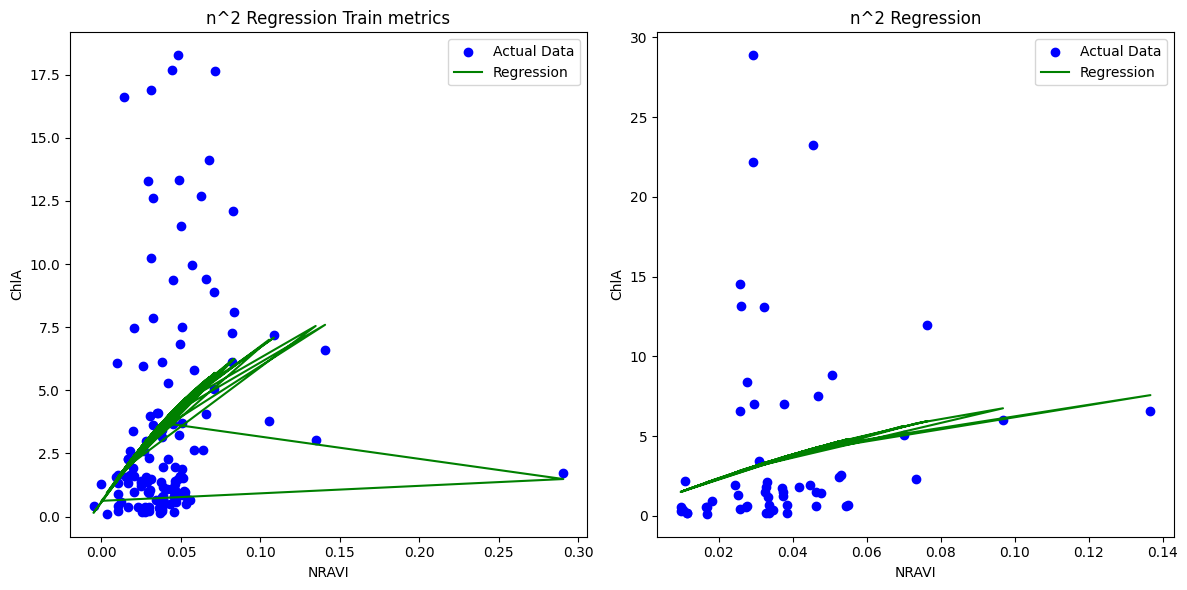

In [81]:
regression(x='NRAVI',
           y='ChlA',
           train_data=train_data,
           test_data=test_data,
           run_name='NRAVI quadratic',
           degree=2)

#### Red/Green quadratic


n^2 Regression:
Test Mean Squared Error (MSE): 39.56114064160308
Test Root Mean Squared Error (RMSE): 6.289764752485031
Test Mean Absolute Error (MAE): 4.067515298600602 
Test Mean Absolute Percentage Error (MAPE): 3.932551745979776
R-squared: -0.03727164354916224


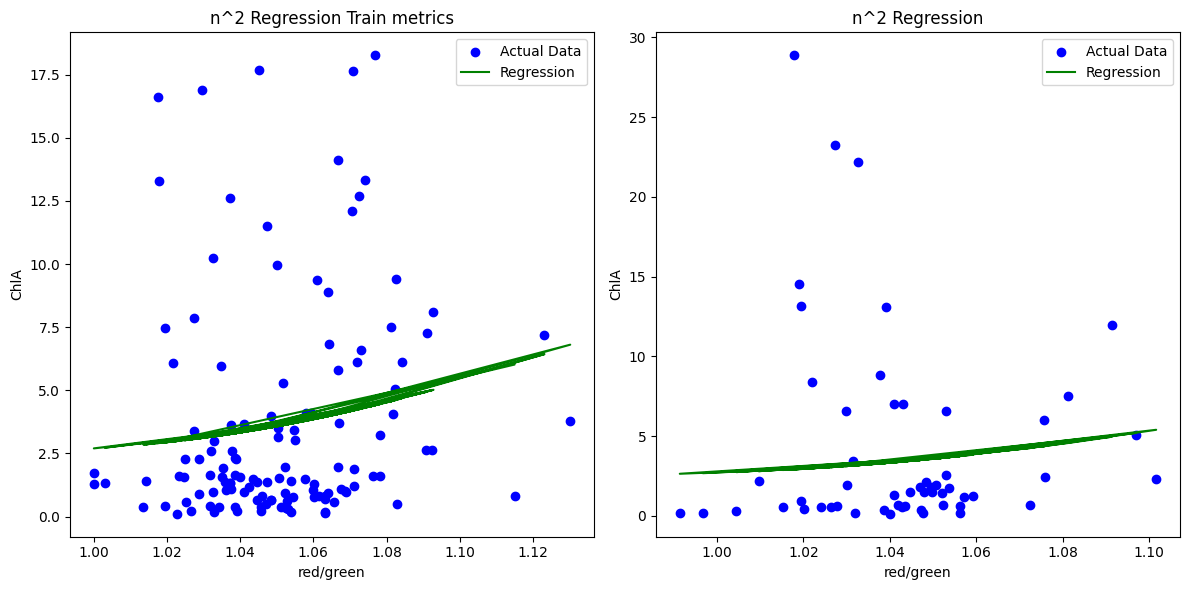

In [82]:
regression(x='red/green',
           y='ChlA',
           train_data=train_data,
           test_data=test_data,
           run_name='Red/Green quadratic',
           degree=2)

#### red_edge(nir)/green quadratic


n^2 Regression:
Test Mean Squared Error (MSE): 37.738881973079856
Test Root Mean Squared Error (RMSE): 6.143198024895491
Test Mean Absolute Error (MAE): 3.8477062980164347 
Test Mean Absolute Percentage Error (MAPE): 3.2907408816759083
R-squared: 0.01050699006493161


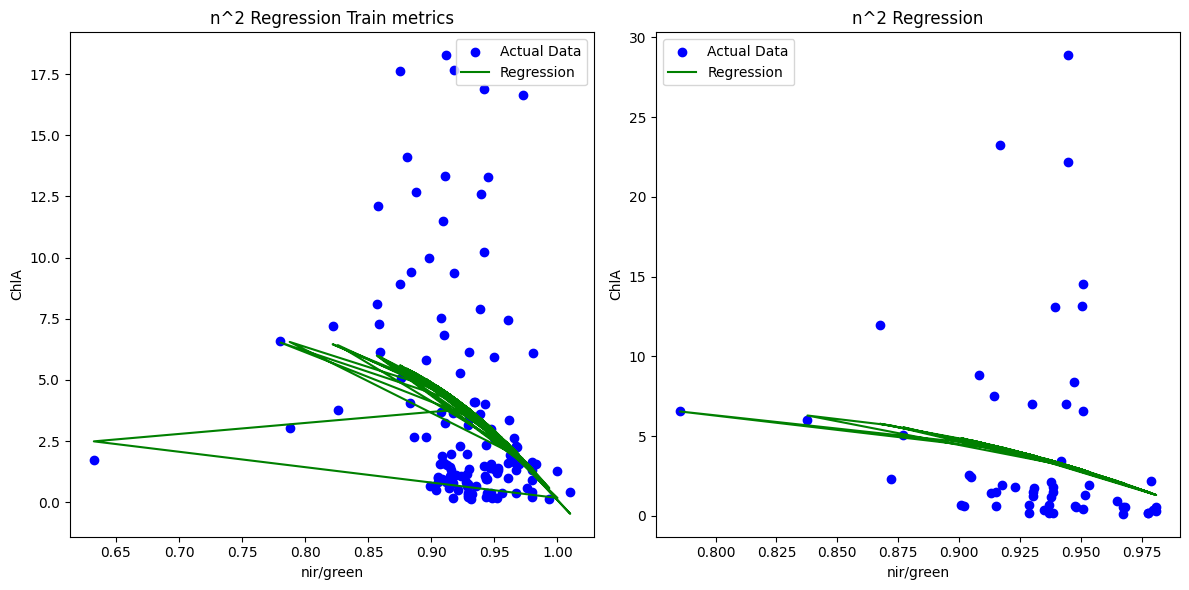

In [83]:
regression(x='nir/green',
           y='ChlA',
           train_data=train_data,
           test_data=test_data,
           run_name="red_edge(nir)/green quadratic",
           degree=2)

#### SWIR2 Linear


n^1 Regression:
Test Mean Squared Error (MSE): 38.22976481556261
Test Root Mean Squared Error (RMSE): 6.183022304307386
Test Mean Absolute Error (MAE): 4.202668414643591 
Test Mean Absolute Percentage Error (MAPE): 4.609619480107695
R-squared: -0.0023636917342861885


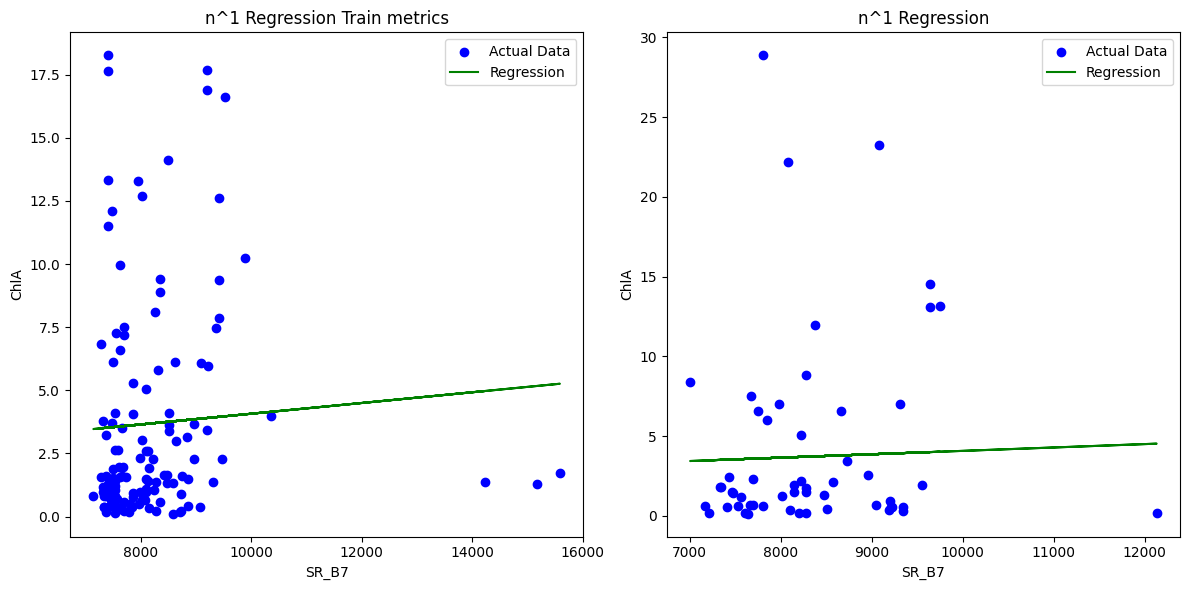

In [84]:
regression(x='SR_B7',
           y='ChlA',
           train_data=train_data,
           test_data=test_data,
           run_name="SWIR2 Linear",
           degree=1)

#### swir2/green quadratic


n^2 Regression:
Test Mean Squared Error (MSE): 38.99314487126778
Test Root Mean Squared Error (RMSE): 6.244449124724116
Test Mean Absolute Error (MAE): 4.180487747282208 
Test Mean Absolute Percentage Error (MAPE): 4.323754476831113
R-squared: -0.022379102619614732


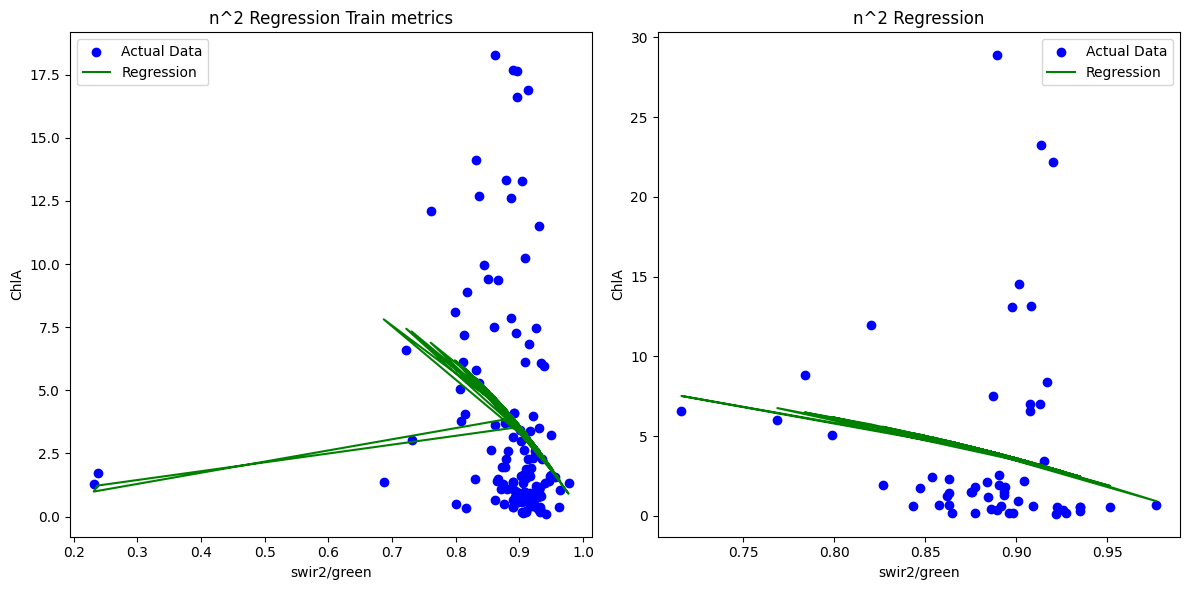

In [85]:
regression(x='swir2/green',
           y='ChlA',
           train_data=train_data,
           test_data=test_data,
           run_name="swir2/green quadratic",
           degree=2)

#### swir2/red linear


n^1 Regression:
Test Mean Squared Error (MSE): 38.31760143569768
Test Root Mean Squared Error (RMSE): 6.190121277947442
Test Mean Absolute Error (MAE): 4.188379560122041 
Test Mean Absolute Percentage Error (MAPE): 4.5235506823021066
R-squared: -0.004666720258076795


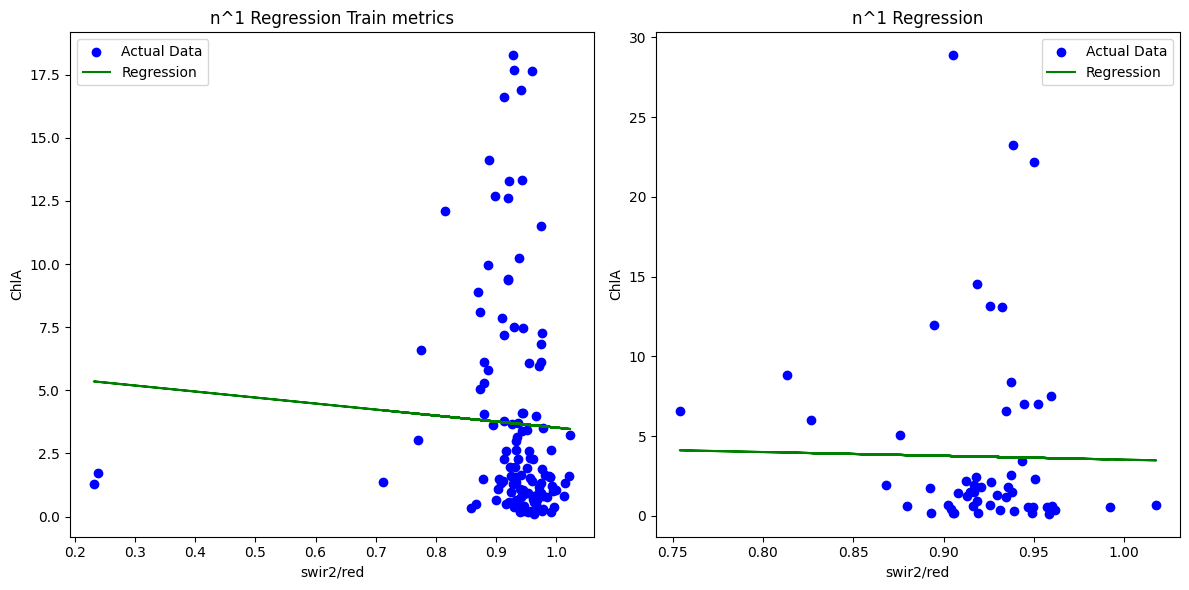

In [86]:
regression(x='swir2/red',
           y='ChlA',
           train_data=train_data,
           test_data=test_data,
           run_name="swir2/red linear",
           degree=1)

#### swir2/rededge(nir) linear


n^1 Regression:
Test Mean Squared Error (MSE): 38.396527059236924
Test Root Mean Squared Error (RMSE): 6.196493125892816
Test Mean Absolute Error (MAE): 4.207225589081292 
Test Mean Absolute Percentage Error (MAPE): 4.526027647881651
R-squared: -0.006736107285825854


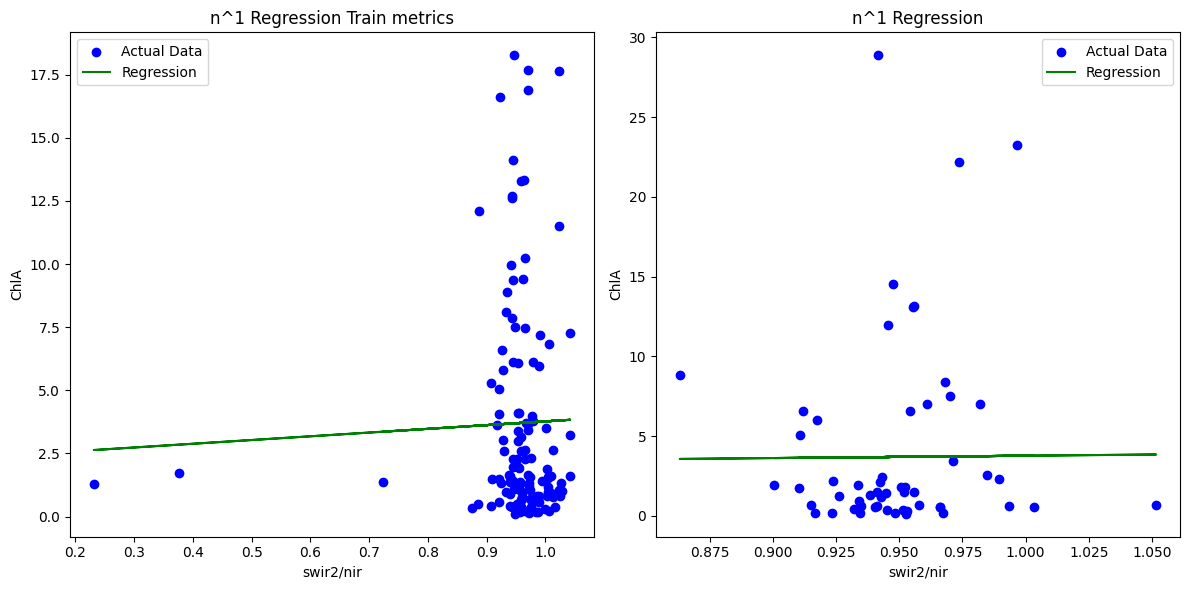

In [87]:
regression(x='swir2/nir',
           y='ChlA',
           train_data=train_data,
           test_data=test_data,
           run_name="swir2/rededge(nir)",
           degree=1)

## RNA's

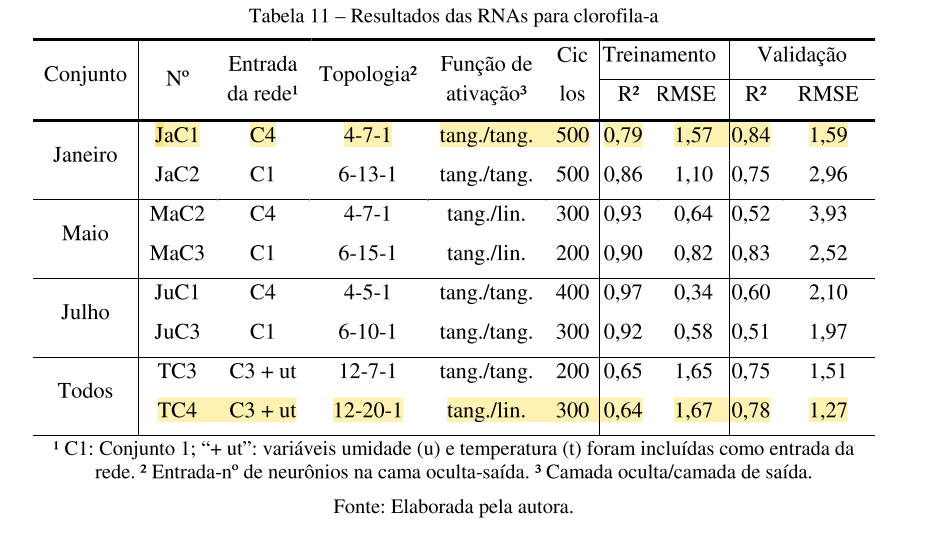

### Experiment 1

#### Preprocessing Baseline 1 data



##### Selecting the experiment's fields


In [88]:
experiment1_train_data = train_data[['NDWI', 'NDVI', 'NRAVI', 'ChlA']]
experiment1_test_data = test_data[['NDWI', 'NDVI', 'NRAVI', 'ChlA']]

In [89]:
experiment1_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 85 to 102
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NDWI    126 non-null    float64
 1   NDVI    126 non-null    float64
 2   NRAVI   126 non-null    float64
 3   ChlA    126 non-null    float64
dtypes: float64(4)
memory usage: 4.9 KB


##### Split and normalize the data



In [90]:
# Get the default field
X_train, y_train = experiment1_train_data.drop(columns=['ChlA']), experiment1_train_data[['ChlA']]
X_test, y_test = experiment1_test_data.drop(columns=['ChlA']), experiment1_test_data[['ChlA']]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (126, 3), y_train: (126, 1)
X_test: (55, 3), y_test: (55, 1)


In [91]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data only
scaler.fit(X_train)

# Transform both the training and testing data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrames (optional but recommended)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"X_train scaled: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test scaled: {X_test.shape}, y_test: {y_test.shape}")

X_train scaled: (126, 3), y_train: (126, 1)
X_test scaled: (55, 3), y_test: (55, 1)


#### Train e validate

Vamos usar o conjunto de 4 entradas normalizadas:

> - NDVI
- NDWI
- NDCI (Não disponível para o Landsat por conta da banda red edge)
- NRAVI

In [92]:
param_grid_mlp = {
    'hidden_layer_sizes': [(7), (13), (15), (5), (10),(20)],  # Number of neurons in each hidden layer
    'activation': ['relu', 'tanh', 'identity', 'logistic'],  # Activation function for hidden layers
    'solver': ['lbfgs', 'adam',  'sgd'],  # Optimization algorithm
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term) parameter
    'max_iter': [300] # Maximum number of iterations
}


In [93]:
# Create the MLPClassifier
mlp_classifier = MLPRegressor(random_state=42)

# Create the GridSearchCV object for MLP
grid_search_mlp = GridSearchCV(estimator=mlp_classifier,
                             param_grid=param_grid_mlp,
                             cv=5,  # Number of cross-validation folds
                             scoring='neg_mean_absolute_percentage_error',  # Evaluation metric
                             n_jobs=-1,  # Use all available CPU cores
                             verbose=2) # More verbose output

# Fit the GridSearchCV object to the training data
grid_search_mlp.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPRegressor(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'identity', 'logistic'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [7, 13, 15, 5, 10, 20],
                         'max_iter': [300],
                         'solver': ['lbfgs', 'adam', 'sgd']},
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [94]:
# Get the best MLP model and its hyperparameters
best_mlp_model = grid_search_mlp.best_estimator_
print("Best Hyperparameters for MLP:", grid_search_mlp.best_params_)

# Evaluate the best MLP model on the test set
y_pred_mlp = best_mlp_model.predict(X_test)

Best Hyperparameters for MLP: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 5, 'max_iter': 300, 'solver': 'adam'}


In [95]:
metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_mlp)
metrics

{'MSE': 49.891603145664206,
 'RMSE': 7.063398838071103,
 'MAE': 3.713116062419947,
 'MAPE': 1.0351386206219222,
 'r2_quadratic': -0.3081307655670422}

In [96]:
with mlflow.start_run(run_name='MLP NDVI, NDWI, NRAVI'):
    mlflow.log_metrics(metrics)
    mlflow.log_params(grid_search_mlp.best_params_)

### Experiment 2

#### Preprocessing Baseline data 2

##### Selecting the experiment's fields


In [97]:
experiment2_train_data = train_data[['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','ST_B6','SR_B7', 'ChlA']]
experiment2_test_data = test_data[['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','ST_B6','SR_B7', 'ChlA']]

In [98]:
experiment2_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 85 to 102
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SR_B1   126 non-null    float64
 1   SR_B2   126 non-null    float64
 2   SR_B3   126 non-null    float64
 3   SR_B4   126 non-null    float64
 4   SR_B5   126 non-null    float64
 5   ST_B6   126 non-null    float64
 6   SR_B7   126 non-null    float64
 7   ChlA    126 non-null    float64
dtypes: float64(8)
memory usage: 8.9 KB


##### Split and normalize the data

In [99]:
# Get the default field
X_train, y_train = experiment2_train_data.drop(columns=['ChlA']), experiment2_train_data[['ChlA']]
X_test, y_test = experiment2_test_data.drop(columns=['ChlA']), experiment2_test_data[['ChlA']]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (126, 7), y_train: (126, 1)
X_test: (55, 7), y_test: (55, 1)


In [100]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data only
scaler.fit(X_train)

# Transform both the training and testing data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrames (optional but recommended)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"X_train scaled: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test scaled: {X_test.shape}, y_test: {y_test.shape}")

X_train scaled: (126, 7), y_train: (126, 1)
X_test scaled: (55, 7), y_test: (55, 1)


#### Train e validate

Vamos usar o conjunto de 9 entradas:

> - SR_B1
- SR_B2
- SR_B3
- SR_B4
- SR_B5
- ST_B6
- SR_B7
- Temp
- Um (Umidade que aida falta inserir nos dados)

In [101]:
# Create the MLPClassifier
mlp_classifier = MLPRegressor(random_state=42)

# Create the GridSearchCV object for MLP
grid_search_mlp = GridSearchCV(estimator=mlp_classifier,
                             param_grid=param_grid_mlp,
                             cv=5,  # Number of cross-validation folds
                             scoring='neg_mean_absolute_percentage_error',  # Evaluation metric
                             n_jobs=-1,  # Use all available CPU cores
                             verbose=2) # More verbose output

# Fit the GridSearchCV object to the training data
grid_search_mlp.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPRegressor(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'identity', 'logistic'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [7, 13, 15, 5, 10, 20],
                         'max_iter': [300],
                         'solver': ['lbfgs', 'adam', 'sgd']},
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [102]:
# Get the best MLP model and its hyperparameters
best_mlp_model = grid_search_mlp.best_estimator_
print("Best Hyperparameters for MLP:", grid_search_mlp.best_params_)

# Evaluate the best MLP model on the test set
y_pred_mlp = best_mlp_model.predict(X_test)

Best Hyperparameters for MLP: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 7, 'max_iter': 300, 'solver': 'adam'}


In [103]:
metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_mlp)

In [104]:
with mlflow.start_run(run_name='Landsat 5 all bands'):
    mlflow.log_metrics(metrics)
    mlflow.log_params(grid_search_mlp.best_params_)

## Results


In [6]:
!nohup mlflow ui --port 5001 --backend-store-uri file:///content/drive/MyDrive/water_quality/mobile_bay/notebooks/TCC/mlflow_logs &

nohup: appending output to 'nohup.out'


In [7]:
NGROK_AUTH_TOKEN = "2sZm1YO3IJJnEy8pmUVG3HMoXIp_3Nn6QnMQJGQwUbNUVCXPh"
!ngrok config add-authtoken SEU_AUTHTOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [8]:
ngrok.kill()

ngrok.set_auth_token(NGROK_AUTH_TOKEN)
url = ngrok.connect(5001, "http")
print("Acesse o MLflow UI aqui:", url.public_url)

Acesse o MLflow UI aqui: https://43f8-34-73-192-232.ngrok-free.app
